In [1]:
pip install evaluate

Note: you may need to restart the kernel to use updated packages.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/geometry3k/data-00000-of-00001.arrow


In [3]:
import os
from datasets import Dataset

def load_geometry3k_dataset():
    """
    Loads the Geometry3K dataset from the Arrow file in the current directory.

    :return: A Hugging Face Dataset object.
    """
    arrow_file_path = "/kaggle/input/geometry3k/data-00000-of-00001.arrow"

    # Load the dataset from the Arrow file
    dataset = Dataset.from_file(arrow_file_path)

    return dataset

def get_train_val_test_splits(dataset):
    """
    Splits the dataset into train, validation, and test sets.
    - Train: first 2101 samples
    - Validation: next 300 samples
    - Test: remaining samples
    """
    total_samples = dataset.num_rows
    train_end = min(2101, total_samples)
    val_end = min(train_end + 300, total_samples)

    train_dataset = dataset.select(range(0, train_end))
    val_dataset   = dataset.select(range(train_end, val_end))
    test_dataset  = dataset.select(range(val_end, total_samples))

    return {
        "train": train_dataset,
        "validation": val_dataset,
        "test": test_dataset
    }

# Load and split the dataset
dataset = load_geometry3k_dataset()
dataset_splits = get_train_val_test_splits(dataset)

# Show basic info
print("Train samples:", len(dataset_splits["train"]))
print("Validation samples:", len(dataset_splits["validation"]))
print("Test samples:", len(dataset_splits["test"]))

# Display the first training sample
print(dataset_splits["train"][0])


Train samples: 2101
Validation samples: 300
Test samples: 501
{'images': [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=648x405 at 0x7AB6B67C84F0>], 'problem': '<image>Find $x$.', 'answer': '2', 'id': 84, 'choices': ['1', '2', '3', '4'], 'ground_truth': 'B'}


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import AutoProcessor, AutoModel
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import evaluate
from tqdm.auto import tqdm
from torchvision import transforms


# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
set_seed()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
from torchvision import transforms

# Enhanced data augmentation for training
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop with resize
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # Increased rotation range slightly
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.05),  # Occasional grayscale conversion
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),  # Add blur augmentation
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),  # Occasional sharpening
    # Add random perspective to simulate different viewing angles
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
])

# Evaluation transforms remain simple
eval_transforms = transforms.Compose([
    transforms.Resize((224, 224))
])

In [6]:
def freeze_early_layers(model, freeze_text_layers=2, freeze_vision_layers=4):
    """
    Freezes early layers of the vision and text encoders in the VLM.
    
    :param model: The GeometryVLM instance.
    :param freeze_text_layers: Number of text encoder layers to freeze.
    :param freeze_vision_layers: Number of vision encoder layers to freeze.
    """
    # Freeze early text layers (assuming layer names in the text encoder follow this pattern)
    for name, param in model.vlm.named_parameters():
        # Check for text encoder layers:
        if "text_model.encoder.layer" in name:
            # Attempt to extract the layer number
            try:
                # Example of name: 'text_model.encoder.layer.0.attention.self.query.weight'
                layer_num = int(name.split('.')[3])
            except Exception:
                continue
            if layer_num < freeze_text_layers:
                param.requires_grad = False
                # Uncomment the next line to debug which parameters are frozen
                # print("Frozen:", name)

        # Freeze early vision layers (assuming similar naming convention)
        if "vision_model.encoder.layer" in name:
            try:
                # Example of name: 'vision_model.encoder.layer.0.attention.self.query.weight'
                layer_num = int(name.split('.')[3])
            except Exception:
                continue
            if layer_num < freeze_vision_layers:
                param.requires_grad = False
                # Uncomment the next line to debug which parameters are frozen
                # print("Frozen:", name)
def freeze_early_layers(model, freeze_text_layers=2, freeze_vision_layers=4):
    """
    Freezes early layers of the vision and text encoders in the VLM.
    
    :param model: The GeometryVLM instance.
    :param freeze_text_layers: Number of text encoder layers to freeze.
    :param freeze_vision_layers: Number of vision encoder layers to freeze.
    """
    # Freeze early text layers (assuming layer names in the text encoder follow this pattern)
    for name, param in model.vlm.named_parameters():
        # Check for text encoder layers:
        if "text_model.encoder.layer" in name:
            # Attempt to extract the layer number
            try:
                # Example of name: 'text_model.encoder.layer.0.attention.self.query.weight'
                layer_num = int(name.split('.')[3])
            except Exception:
                continue
            if layer_num < freeze_text_layers:
                param.requires_grad = False
                # Uncomment the next line to debug which parameters are frozen
                # print("Frozen:", name)

        # Freeze early vision layers (assuming similar naming convention)
        if "vision_model.encoder.layer" in name:
            try:
                # Example of name: 'vision_model.encoder.layer.0.attention.self.query.weight'
                layer_num = int(name.split('.')[3])
            except Exception:
                continue
            if layer_num < freeze_vision_layers:
                param.requires_grad = False
                # Uncomment the next line to debug which parameters are frozen
                # print("Frozen:", name)


In [7]:
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset

class Geometry3KDataset(Dataset):
    def __init__(self, dataset, processor, max_length=64, transform=None):
        """
        :param dataset: The raw dataset (e.g., Hugging Face Dataset).
        :param processor: The processor for text and image.
        :param max_length: Max token length for text processing.
        :param transform: A torchvision transforms pipeline for images.
        """
        self.dataset = dataset
        self.processor = processor
        self.max_length = max_length
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        
        # Get the image
        image = item['images'][0]
        
        # Convert to PIL Image if necessary, and ensure mode is RGB
        if not isinstance(image, Image.Image):
            image = Image.open(image)
        if image.mode != "RGB":
            image = image.convert("RGB")
        
        # Apply data augmentation transform if provided
        if self.transform:
            image = self.transform(image)
        
        # Improved text formatting with clearer structure
        problem_text = item['problem'].strip()
        choices = item['choices']
        
        # Add a clear prompt to help the model understand the task
        full_prompt = f"Solve this geometry problem:\n\n{problem_text}\n\n"
        full_prompt += "Choose the correct option from:\n"
        
        for i, choice in enumerate(choices):
            full_prompt += f"Option {chr(65+i)}: {choice}\n"
        
        # Process inputs using the processor
        inputs = self.processor(
            text=full_prompt,
            images=image,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt"
        )
        
        # Remove batch dimension from the processor outputs
        for k, v in inputs.items():
            inputs[k] = v.squeeze(0)
        
        # Convert ground truth into label (e.g., for A, B, C, D)
        target_label = ord(item['ground_truth']) - ord('A')
        
        return {
            "inputs": inputs,
            "labels": torch.tensor(target_label, dtype=torch.long),
            "id": item['id']
        }

In [8]:
class GeometryVLM(nn.Module):
    def __init__(self, model_name="google/siglip-base-patch16-224", dropout_rate=0.5):
        super(GeometryVLM, self).__init__()
        self.vlm = AutoModel.from_pretrained(model_name)
        
        # Determine hidden size from the model config
        if hasattr(self.vlm.config, "projection_dim"):
            hidden_size = self.vlm.config.projection_dim
        elif hasattr(self.vlm.config, "vision_config") and hasattr(self.vlm.config.vision_config, "hidden_size"):
            hidden_size = self.vlm.config.vision_config.hidden_size
        elif hasattr(self.vlm.config, "text_config") and hasattr(self.vlm.config.text_config, "hidden_size"):
            hidden_size = self.vlm.config.text_config.hidden_size
        else:
            raise ValueError("Could not determine hidden size from model config.")
        
        # Enhanced classifier with stronger regularization
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.LayerNorm(512),  # Layer normalization for better stability
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 4)
        )
        
    def forward(self, inputs):
        pixel_values = inputs.get("pixel_values")
        input_ids = inputs.get("input_ids")
        attention_mask = inputs.get("attention_mask")
        
        outputs = self.vlm(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            return_dict=True
        )
        
        # Try to use pooler_output if available;
        # otherwise, fall back to text_embeds if they exist.
        pooled_output = getattr(outputs, "pooler_output", None)
        if pooled_output is None:
            if hasattr(outputs, "text_embeds"):
                pooled_output = outputs.text_embeds
            else:
                raise ValueError("Could not retrieve a pooled output from the SigLIP model.")
        
        logits = self.classifier(pooled_output)
        return logits

In [9]:
def train_epoch(model, dataloader, optimizer, criterion, device, accumulation_steps=2):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    # Initialize scaler for mixed precision training
    scaler = torch.cuda.amp.GradScaler()
    
    progress_bar = tqdm(dataloader, desc="Training")
    
    # Zero the gradients at the beginning
    optimizer.zero_grad()
    
    for i, batch in enumerate(progress_bar):
        # Move batch to device
        inputs = batch["inputs"]
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = batch["labels"].to(device)
        
        # Forward pass with mixed precision
        with torch.cuda.amp.autocast():
            logits = model(inputs)
            loss = criterion(logits, labels)
            # Scale loss by accumulation steps
            loss = loss / accumulation_steps
        
        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        
        # Update weights if we've accumulated enough gradients
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(dataloader):
            # Unscale gradients for proper clipping
            scaler.unscale_(optimizer)
            
            # Clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Update weights
            scaler.step(optimizer)
            scaler.update()
            
            # Zero gradients
            optimizer.zero_grad()
        
        # Update metrics
        total_loss += loss.item() * accumulation_steps  # Adjust for accumulation
        
        # Calculate accuracy
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        # Update progress bar
        progress_bar.set_postfix({"loss": loss.item() * accumulation_steps, "accuracy": correct/total})
    
    return total_loss / len(dataloader), correct / total

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Move batch to device
            inputs = batch["inputs"]
            for k, v in inputs.items():
                inputs[k] = v.to(device)
            labels = batch["labels"].to(device)
            
            # Forward pass
            logits = model(inputs)
            
            # Compute loss
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            # Get predictions
            _, predicted = torch.max(logits, 1)
            
            # Store predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
    
    return total_loss / len(dataloader), accuracy, all_preds, all_labels

In [10]:
def train_and_evaluate(model, train_dataloader, val_dataloader, optimizer, criterion, scheduler, num_epochs, device, patience=3):
    best_val_loss = float('inf')
    best_val_acc = 0.0
    counter = 0  # Counter for early stopping
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}\n")
        
        # Train
        train_loss, train_acc = train_epoch(model, train_dataloader, optimizer, criterion, device)
        
        # Evaluate
        val_loss, val_acc, _, _ = evaluate_model(model, val_dataloader, criterion, device)
        
        # Update learning rate based on validation loss
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            scheduler.step()
        
        # Record metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
        
        # Save best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_geometry_model_acc.pth")
            print("Saved new best model based on accuracy!")
            counter = 0  # Reset counter
        elif val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_geometry_model_loss.pth")
            print("Saved new best model based on loss!")
            counter = 0  # Reset counter
        else:
            counter += 1
            print(f"EarlyStopping counter: {counter} out of {patience}")
            
        # Check for early stopping
        if counter >= patience:
            print("Early stopping triggered")
            break
        
        print()  # Empty line for better readability
    
    # Plot training curves
    plot_training_curves(train_losses, val_losses, "Loss")
    plot_training_curves(train_accs, val_accs, "Accuracy")
    
    return train_losses, train_accs, val_losses, val_accs

def plot_training_curves(train_metric, val_metric, metric_name):
    plt.figure(figsize=(10, 6))
    plt.plot(train_metric, label=f'Training {metric_name}')
    plt.plot(val_metric, label=f'Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title(f'Training and Validation {metric_name}')
    plt.grid(True)
    plt.savefig(f'{metric_name.lower()}_curve.png')
    plt.show()

In [11]:
def setup_optimizer_and_scheduler(model, train_dataloader, num_epochs):
    # Separate parameters for different learning rates
    no_decay = ['bias', 'LayerNorm.weight']
    
    # Group parameters: higher learning rate for classifier, lower for base model
    optimizer_grouped_parameters = [
        {
            'params': [p for n, p in model.classifier.named_parameters()],
            'lr': 5e-5,  # Higher learning rate for classifier
            'weight_decay': 0.01
        },
        {
            'params': [p for n, p in model.vlm.named_parameters() 
                      if any(nd in n for nd in no_decay) and p.requires_grad],
            'lr': 1e-5,
            'weight_decay': 0.0  # No weight decay for bias and LayerNorm
        },
        {
            'params': [p for n, p in model.vlm.named_parameters() 
                      if not any(nd in n for nd in no_decay) and p.requires_grad],
            'lr': 1e-5,
            'weight_decay': 0.01
        }
    ]
    
    # Use AdamW optimizer
    optimizer = optim.AdamW(optimizer_grouped_parameters)
    
    # One cycle learning rate scheduler
    steps_per_epoch = len(train_dataloader)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=[5e-5, 1e-5, 1e-5],  # Match the learning rates from above
        pct_start=0.1,  # Warm up for 10% of training
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch
    )
    
    return optimizer, scheduler

In [14]:
def visualize_predictions(model, test_dataset, test_dataloader, processor, num_samples=5):
    """
    Visualizes model predictions on a few test samples.
    
    :param model: Trained model
    :param test_dataset: Test dataset
    :param test_dataloader: Test dataloader
    :param processor: Image/text processor
    :param num_samples: Number of samples to visualize
    """
    model.eval()
    
    # Get a batch of data
    batch = next(iter(test_dataloader))
    indices = range(min(num_samples, len(batch["labels"])))
    
    with torch.no_grad():
        # Move inputs to device
        inputs = batch["inputs"]
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        
        # Get predictions
        logits = model(inputs)
        _, predictions = torch.max(logits, 1)
        
        # Map predictions and ground truth to option letters
        pred_options = [chr(65 + p.item()) for p in predictions]
        true_options = [chr(65 + l.item()) for l in batch["labels"]]
        
    # Display the samples with predictions
    plt.figure(figsize=(15, num_samples * 5))
    
    for i, idx in enumerate(indices):
        # IMPORTANT FIX: The batch index is not the same as the dataset index!
        # Instead of using batch["id"], we'll use the actual batch items
        
        # Get the input data directly from the batch
        sample_data = {
            "inputs": {k: v[idx].unsqueeze(0) for k, v in batch["inputs"].items()},
            "labels": batch["labels"][idx].unsqueeze(0)
        }
        
        # For visualization, get the original image from the dataset object
        # This avoids using the ID directly as an index
        image = None
        try:
            # Get image from dataset_idx if available in the batch
            if "dataset_idx" in batch:
                dataset_idx = batch["dataset_idx"][idx].item()
                original_item = test_dataset.dataset[dataset_idx]
                image = original_item['images'][0]
            else:
                # If there's no dataset_idx, use the processed image directly
                pixel_values = batch["inputs"]["pixel_values"][idx].cpu().numpy()
                # Denormalize and convert to PIL Image
                image = denormalize_image(pixel_values)
        except Exception as e:
            print(f"Error accessing image: {e}")
            # Create a blank image if we can't get the original
            image = Image.new('RGB', (224, 224), color='lightgray')
        
        # Ensure we have a PIL Image
        if not isinstance(image, Image.Image):
            try:
                image = Image.open(image)
            except:
                # If we can't load it as a PIL Image, create a blank one
                image = Image.new('RGB', (224, 224), color='lightgray')
        
        if image.mode != "RGB":
            image = image.convert("RGB")
        
        # Display image and prediction information
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(image)
        
        # Create title with information
        problem_text = f"Sample {i+1}"
        if "dataset_idx" in batch:
            dataset_idx = batch["dataset_idx"][idx].item()
            try:
                problem_text = test_dataset.dataset[dataset_idx]['problem'][:100] + "..."
            except:
                pass
        
        plt.title(f"Problem: {problem_text}\n"
                 f"Prediction: {pred_options[i]}, Ground Truth: {true_options[i]}", 
                 fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('predictions_visualization.png')
    plt.show()
    
    # Print basic analysis of these samples
    print("\nSample Predictions:")
    for i, idx in enumerate(indices):
        print(f"Sample {i+1}: Predicted {pred_options[i]}, Ground Truth {true_options[i]}")

def denormalize_image(img_array):
    """Convert a normalized image tensor back to a PIL Image for visualization"""
    # Reshape if needed
    if img_array.shape[0] == 3:  # If channels are first
        img_array = np.transpose(img_array, (1, 2, 0))
    
    # Scale back to 0-255 range assuming normalization is roughly to [-1, 1] or [0, 1]
    if img_array.min() < 0:
        # Assume [-1, 1] range
        img_array = (img_array + 1) * 127.5
    else:
        # Assume [0, 1] range
        img_array = img_array * 255
    
    # Clip to valid range and convert to uint8
    img_array = np.clip(img_array, 0, 255).astype(np.uint8)
    
    # Convert to PIL Image
    return Image.fromarray(img_array)

Epoch 1/15



<ipython-input-9-a7e6ebc3e147>:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Training:   0%|          | 0/132 [00:00<?, ?it/s]

<ipython-input-9-a7e6ebc3e147>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 1.4941, Train Accuracy: 0.2637
Val Loss: 1.3897, Val Accuracy: 0.3033
Saved new best model based on accuracy!

Epoch 2/15



Training:   0%|          | 0/132 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00><function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00><function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
            self._shutdown_workers()self._shutdown_workers()self._shutdown_workers()
Exception ignored in: 
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

<function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>  File "/usr/local/lib/pyth

Train Loss: 1.4666, Train Accuracy: 0.2851
Val Loss: 1.3828, Val Accuracy: 0.2733
Saved new best model based on loss!

Epoch 3/15



Training:   0%|          | 0/132 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 1.4402, Train Accuracy: 0.2856
Val Loss: 1.3821, Val Accuracy: 0.3000
Saved new best model based on loss!

Epoch 4/15



Training:   0%|          | 0/132 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>    
if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>    
    assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):
self._shutdown_workers()Exception ignored in: Exception ignored in:   File "/usr/local/lib/python3

Train Loss: 1.4522, Train Accuracy: 0.2822
Val Loss: 1.3801, Val Accuracy: 0.3000
Saved new best model based on loss!

Epoch 5/15



Training:   0%|          | 0/132 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 1.4478, Train Accuracy: 0.2827
Val Loss: 1.3773, Val Accuracy: 0.3033
Saved new best model based on loss!

Epoch 6/15



Training:   0%|          | 0/132 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
Exception ignored

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
            if w.is_alive():self._shutdown_workers()
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _

Train Loss: 1.4280, Train Accuracy: 0.3018
Val Loss: 1.3759, Val Accuracy: 0.3333
Saved new best model based on accuracy!

Epoch 7/15



Training:   0%|          | 0/132 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 1.4283, Train Accuracy: 0.2908
Val Loss: 1.3758, Val Accuracy: 0.3233
Saved new best model based on loss!

Epoch 8/15



Training:   0%|          | 0/132 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00><function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>Exception ignored in: Traceback (most recent call last):


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

          File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
self._shutdown_workers()Traceback (most recent call last):
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

self._shutdown_workers()  F

Train Loss: 1.4256, Train Accuracy: 0.2937
Val Loss: 1.3744, Val Accuracy: 0.3200
Saved new best model based on loss!

Epoch 9/15



Training:   0%|          | 0/132 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 1.4441, Train Accuracy: 0.2703
Val Loss: 1.3732, Val Accuracy: 0.3167
Saved new best model based on loss!

Epoch 10/15



Training:   0%|          | 0/132 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00><function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00><function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>


Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

self._shutdown_workers()    
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
self._shutdown_workers()  File "/usr/loca

Train Loss: 1.4349, Train Accuracy: 0.2856
Val Loss: 1.3720, Val Accuracy: 0.3133
Saved new best model based on loss!

Epoch 11/15



Training:   0%|          | 0/132 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 1.4303, Train Accuracy: 0.2851
Val Loss: 1.3716, Val Accuracy: 0.3267
Saved new best model based on loss!

Epoch 12/15



Training:   0%|          | 0/132 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00><function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    self._shutdown_workers()if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 1.4155, Train Accuracy: 0.2960
Val Loss: 1.3718, Val Accuracy: 0.3300
EarlyStopping counter: 1 out of 5

Epoch 13/15



Training:   0%|          | 0/132 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 1.4091, Train Accuracy: 0.3113
Val Loss: 1.3715, Val Accuracy: 0.3067
Saved new best model based on loss!

Epoch 14/15



Training:   0%|          | 0/132 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Exception ignored in:     
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ab61e2f6b00>
Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
self._shutdown_workers()
    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    

Train Loss: 1.4221, Train Accuracy: 0.2822
Val Loss: 1.3709, Val Accuracy: 0.3133
Saved new best model based on loss!

Epoch 15/15



Training:   0%|          | 0/132 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 1.4114, Train Accuracy: 0.3046
Val Loss: 1.3731, Val Accuracy: 0.3233
EarlyStopping counter: 1 out of 5



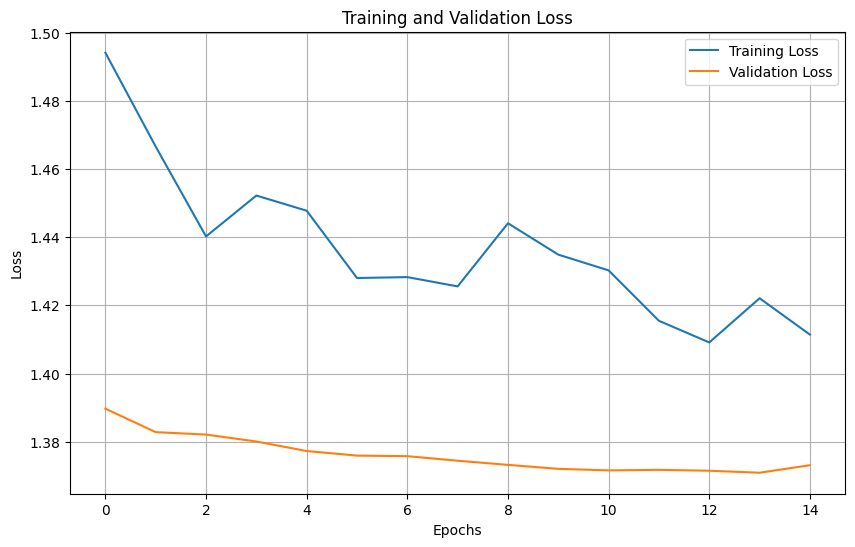

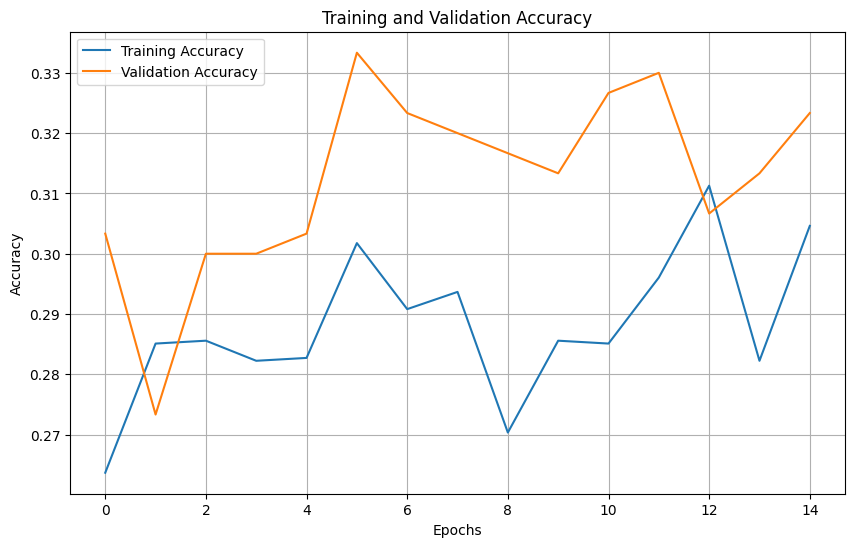

Loading best model by accuracy...


<ipython-input-15-5064eb915556>:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_geometry_model_acc.pth"))


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Test Loss: 1.3708, Test Accuracy: 0.3074


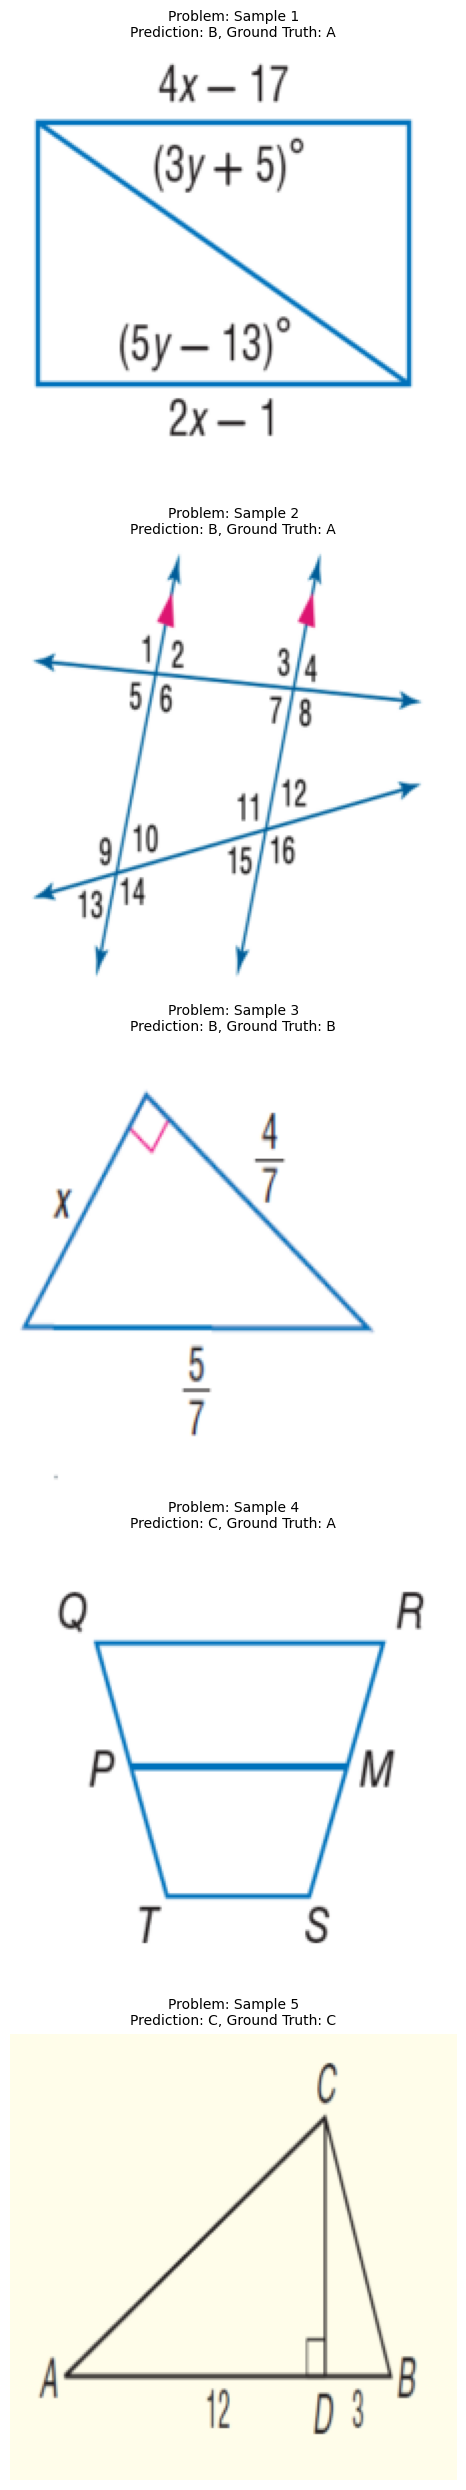


Sample Predictions:
Sample 1: Predicted B, Ground Truth A
Sample 2: Predicted B, Ground Truth A
Sample 3: Predicted B, Ground Truth B
Sample 4: Predicted C, Ground Truth A
Sample 5: Predicted C, Ground Truth C

Loading best model by loss...


<ipython-input-15-5064eb915556>:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_geometry_model_loss.pth"))


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Test Loss: 1.3588, Test Accuracy: 0.3373


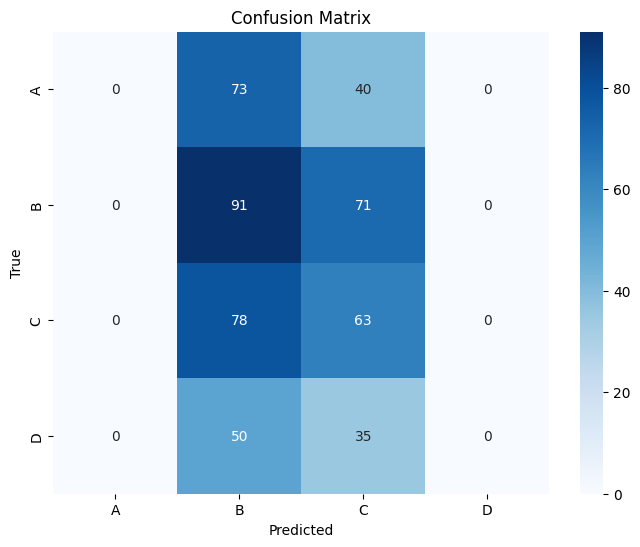


Per-class metrics:
Option A: Precision=0.0000, Recall=0.0000, F1=0.0000
Option B: Precision=0.3116, Recall=0.5617, F1=0.4009
Option C: Precision=0.3014, Recall=0.4468, F1=0.3600
Option D: Precision=0.0000, Recall=0.0000, F1=0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
def main():
    # 1. Try different models
    # Choose one of these model options:
    model_options = {
        "siglip_base": "google/siglip-base-patch16-224",
        "siglip_large": "google/siglip-large-patch16-224",
        "clip_base": "openai/clip-vit-base-patch16",
        "flava": "facebook/flava-full"
    }
    
    # Choose which model to use (can change this to try different models)
    model_choice = "siglip_base"  # or any other key from model_options
    model_name = model_options[model_choice]
    
    # 2. Configure batch size and other hyperparameters based on available resources
    batch_size = 16
    accumulation_steps = 2  # Effectively gives batch size of 32
    max_length = 64  # Increased from 64
    num_epochs = 15
    patience = 5
    
    # 3. Load processor for the selected model
    processor = AutoProcessor.from_pretrained(model_name)
    
    # 4. Prepare datasets with enhanced transforms
    train_dataset = Geometry3KDataset(dataset_splits["train"], processor, max_length=max_length, transform=train_transforms)
    val_dataset = Geometry3KDataset(dataset_splits["validation"], processor, max_length=max_length, transform=eval_transforms)
    test_dataset = Geometry3KDataset(dataset_splits["test"], processor, max_length=max_length, transform=eval_transforms)
    
    # 5. Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)
    
    # 6. Initialize model with higher dropout
    model = GeometryVLM(model_name=model_name, dropout_rate=0.5).to(device)
    
    # 7. Freeze early layers more aggressively
    freeze_early_layers(model, freeze_text_layers=4, freeze_vision_layers=8)
    
    # 8. Setup optimizer and scheduler
    optimizer, scheduler = setup_optimizer_and_scheduler(model, train_dataloader, num_epochs)
    
    # 9. Use label smoothing in the loss function to reduce overfitting
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    # 10. Train with early stopping
    train_losses, train_accs, val_losses, val_accs = train_and_evaluate(
        model, train_dataloader, val_dataloader, optimizer, criterion, scheduler,
        num_epochs, device, patience=patience
    )
    
    # 11. Load the best model by accuracy
    print("Loading best model by accuracy...")
    model.load_state_dict(torch.load("best_geometry_model_acc.pth"))
    
    # 12. Evaluate on test set
    test_loss, test_accuracy, test_preds, test_labels = evaluate_model(model, test_dataloader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    # 13. Generate predictions for visualization
    visualize_predictions(model, test_dataset, test_dataloader, processor, num_samples=5)
    
    # 14. Also try the model saved by loss criterion
    print("\nLoading best model by loss...")
    model.load_state_dict(torch.load("best_geometry_model_loss.pth"))
    test_loss2, test_accuracy2, test_preds2, test_labels2 = evaluate_model(model, test_dataloader, criterion, device)
    print(f"Test Loss: {test_loss2:.4f}, Test Accuracy: {test_accuracy2:.4f}")
    
    # 15. Create confusion matrix to analyze errors
    create_confusion_matrix(test_preds, test_labels)
    
def create_confusion_matrix(predictions, labels):
    # Create and plot confusion matrix
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['A', 'B', 'C', 'D'], 
                yticklabels=['A', 'B', 'C', 'D'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    # Calculate per-class metrics
    precision = precision_score(labels, predictions, average=None)
    recall = recall_score(labels, predictions, average=None)
    f1 = f1_score(labels, predictions, average=None)
    
    # Print per-class metrics
    print("\nPer-class metrics:")
    for i, option in enumerate(['A', 'B', 'C', 'D']):
        print(f"Option {option}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")

if __name__ == "__main__":
    # Add required imports at the top of your script
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
    
    # Set seed for reproducibility
    set_seed(42)
    
    # Run the main function
    main()